<a href="https://www.analytiksinc.com">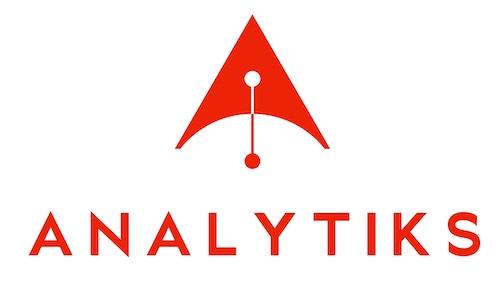</a>
<p style="text-align: right;"> © 2021. Analytiks Inc. </p>

# Time Series Analysis

## Import Libraries

In [42]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Standard Libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

### Additional Libraries

<a href = 'https://facebook.github.io/prophet/docs/installation.html#python'>FBProphet</a>

In [44]:
#FBProphet
from fbprophet import Prophet

#Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Helper Functions

In [50]:
def forecast_metrics(y_true, y_pred):
    """Calculate MAE, MSE, RMSE, and MAPE of the forecast.
    
       Args:
           y_true: actual results
           y_pred: predicted results
    """
    
    #MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    #MSE
    mse = mean_squared_error(y_true, y_pred)
    
    #RMSE
    rmse = np.sqrt(mse)
    
    #MAPE
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
    
    print(("MAE: %.2f") % mae)
    print(("MSE: %.2f") % mse)
    print(("RMSE: %.2f") % rmse)
    print(("MAPE: %.2f") % (mape * 100))
    

## Load and Explore the Dataset

Filename: superstore_sales_data.csv

In [51]:
url = 'https://github.com/ruthypatooty/september_sample/blob/main/superstore_sales_data-edited.csv'
df = pd.read_csv(url, index_col=0)
print(df.head(5))

#df = pd.read_csv('https://github.com/ruthypatooty/september_sample/blob/main/superstore_sales_data-edited.csv', index_col=0, parse_dates=['Request_Date', 'Completion_Date'])

HTTPError: HTTP Error 404: Not Found

View the Dataset

In [35]:
df.head()

,Order_ID,Request_Date,Completion_Date,Customer_ID,Customer_Name
Row_ID,,,,,
1,CA-2017-152156,2017-08-11,2017-11-11,CG-12520,Claire Gute
2,CA-2017-152156,2017-08-11,2017-11-11,CG-12520,Claire Gute
3,CA-2017-138688,2017-12-06,2017-06-16,DV-13045,Darrin Van Huff
4,US-2016-108966,2016-11-10,2016-10-18,SO-20335,Sean O'Donnell
5,US-2016-108966,2016-11-10,2016-10-18,SO-20335,Sean O'Donnell


Check Info

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 1 to 9800
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         9800 non-null   object        
 1   Request_Date     9800 non-null   datetime64[ns]
 2   Completion_Date  9800 non-null   datetime64[ns]
 3   Customer_ID      9800 non-null   object        
 4   Customer_Name    9800 non-null   object        
dtypes: datetime64[ns](2), object(3)
memory usage: 459.4+ KB


In [8]:
df.nunique()

Order_ID           4922
Request_Date       1230
Completion_Date    1326
Customer_ID         793
Customer_Name       793
dtype: int64

Groupby 'Request Date' and get sum of 'Sales', convert to Series for easier manipulation

In [9]:
daily = df.groupby('Completion_Date').agg({'Customer_ID':['count']})

daily.columns = ['Completed_requests']

daily.head()

,Completed_requests
Completion_Date,
2015-01-04,5
2015-01-05,2
2015-01-06,7
2015-01-07,3
2015-01-08,4


Check Start and End Date of the Series

In [10]:
print("Start Date: %s | End Date: %s " % (daily.index.min(),daily.index.max()))

Start Date: 2015-01-04 00:00:00 | End Date: 2019-05-01 00:00:00 


<AxesSubplot:xlabel='Completion_Date'>

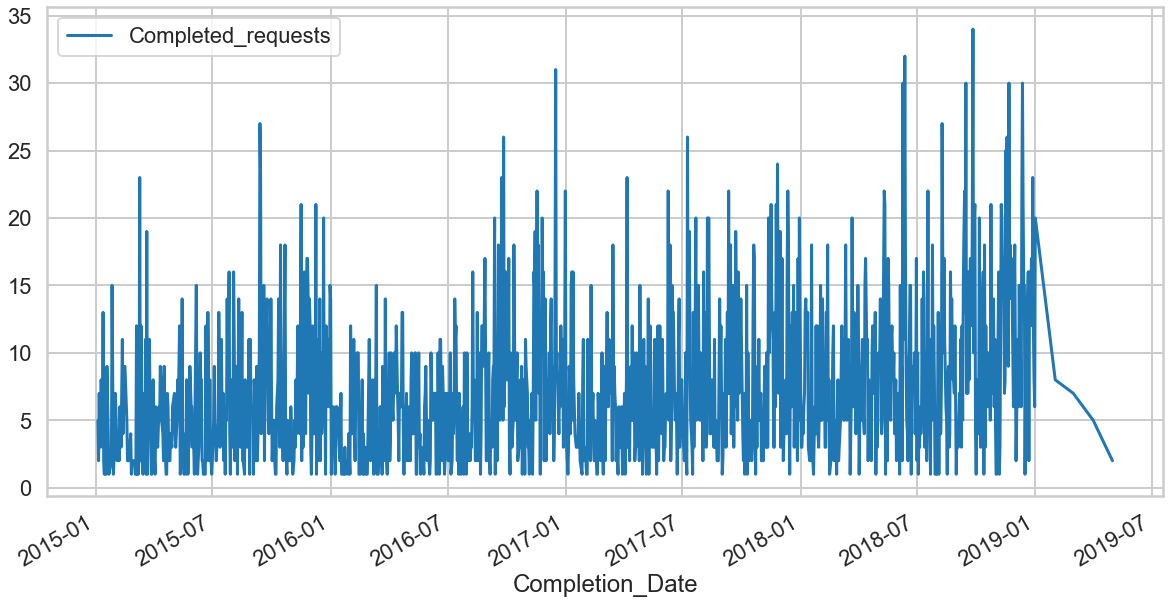

In [11]:
#Plot the Data
daily.plot(kind='line', figsize = (20,10))

In [12]:
#Get Monthly Sales Data
monthly = daily.resample('M').apply(sum)

monthly.head()

,Completed_requests
Completion_Date,
2015-01-31,105
2015-02-28,71
2015-03-31,160
2015-04-30,103
2015-05-31,135


<AxesSubplot:xlabel='Completion_Date'>

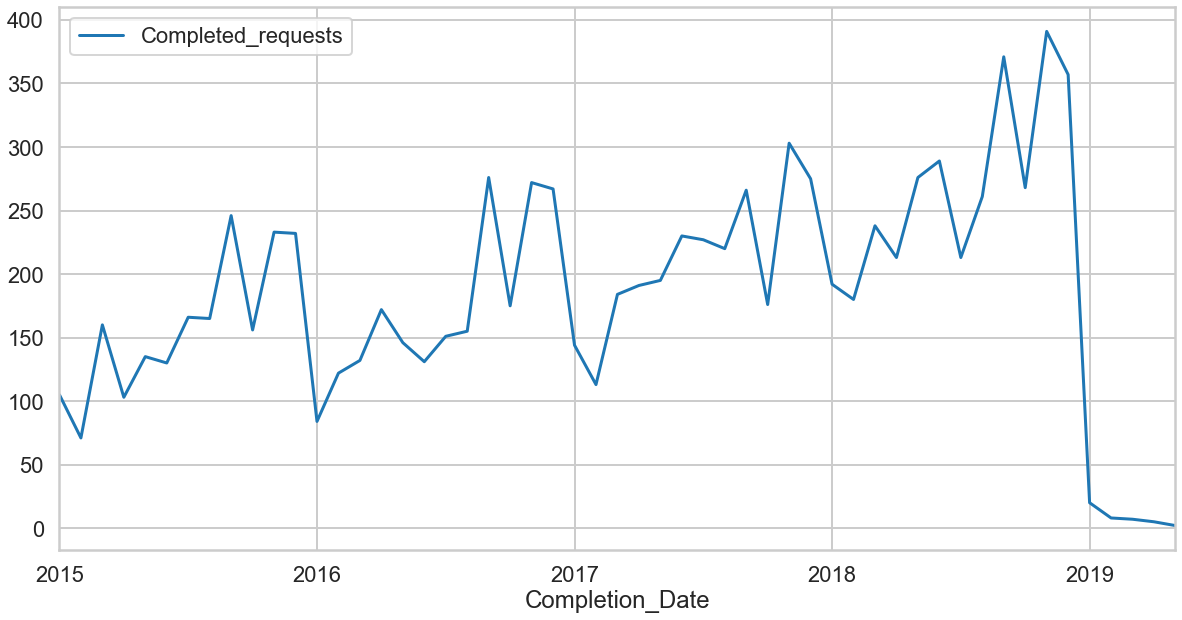

In [13]:
#Plot the Data
monthly.plot(kind='line', figsize = (20,10))

## Split into Train and Test

In [14]:
#We'll use 2018 for testing, and the remaining months and years for training

test = monthly[monthly.index.year == 2018]

train = monthly[monthly.index.year < 2018]

In [15]:
train.shape, test.shape

((36, 1), (12, 1))

In [16]:
print("Train: Start Date: %s |  End Date: %s " % (train.index.min(),train.index.max()))
print("Test: Start Date: %s |  End Date: %s " % (test.index.min(),test.index.max()))

Train: Start Date: 2015-01-31 00:00:00 |  End Date: 2017-12-31 00:00:00 
Test: Start Date: 2018-01-31 00:00:00 |  End Date: 2018-12-31 00:00:00 


_____

## FB Prophet

In [17]:
#Convert our dataframe to the format required by Prophet

train_fb = train.reset_index()
train_fb.columns = ['ds','y']

test_fb = test.reset_index()
test_fb.columns = ['ds','y']

train_fb.head()

,ds,y
0,2015-01-31,105
1,2015-02-28,71
2,2015-03-31,160
3,2015-04-30,103
4,2015-05-31,135


In [18]:
#Instantiate the model

model = Prophet(seasonality_mode='multiplicative')

model.fit(train_fb)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
#Create DataFrame for Forecasts
future = model.make_future_dataframe(periods=12, freq='M')
future

,ds
0,2015-01-31
1,2015-02-28
2,2015-03-31
3,2015-04-30
4,2015-05-31
5,2015-06-30
6,2015-07-31
7,2015-08-31
8,2015-09-30
9,2015-10-31


In [20]:
#Get Forecasts
forecast = model.predict(future)

forecast.tail(n=12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
36,2018-01-31,220.319780,128.312614,168.866096,220.319778,220.319783,-0.328081,-0.328081,-0.328081,-0.328081,-0.328081,-0.328081,0.0,0.0,0.0,148.037079
37,2018-02-28,222.245779,107.451457,149.229826,222.245771,222.245788,-0.425899,-0.425899,-0.425899,-0.425899,-0.425899,-0.425899,0.0,0.0,0.0,127.591508
38,2018-03-31,224.378134,208.807075,249.596319,224.378119,224.378152,0.017514,0.017514,0.017514,0.017514,0.017514,0.017514,0.0,0.0,0.0,228.307832
39,2018-04-30,226.441703,166.398116,204.041939,226.441678,226.441731,-0.184421,-0.184421,-0.184421,-0.184421,-0.184421,-0.184421,0.0,0.0,0.0,184.681163
40,2018-05-31,228.574058,183.553975,225.427531,228.574020,228.574097,-0.106496,-0.106496,-0.106496,-0.106496,-0.106496,-0.106496,0.0,0.0,0.0,204.231917
41,2018-06-30,230.637628,190.146077,227.440519,230.637575,230.637682,-0.091709,-0.091709,-0.091709,-0.091709,-0.091709,-0.091709,0.0,0.0,0.0,209.486124
42,2018-07-31,232.769983,216.747283,257.987907,232.769915,232.770051,0.015117,0.015117,0.015117,0.015117,0.015117,0.015117,0.0,0.0,0.0,236.288674
43,2018-08-31,234.902338,211.441655,252.997779,234.902252,234.902424,-0.013793,-0.013793,-0.013793,-0.013793,-0.013793,-0.013793,0.0,0.0,0.0,231.662356
44,2018-09-30,236.965908,308.862328,348.692377,236.965804,236.966012,0.387689,0.387689,0.387689,0.387689,0.387689,0.387689,0.0,0.0,0.0,328.834944
45,2018-10-31,239.098263,191.064468,231.292789,239.098141,239.098384,-0.113586,-0.113586,-0.113586,-0.113586,-0.113586,-0.113586,0.0,0.0,0.0,211.940136


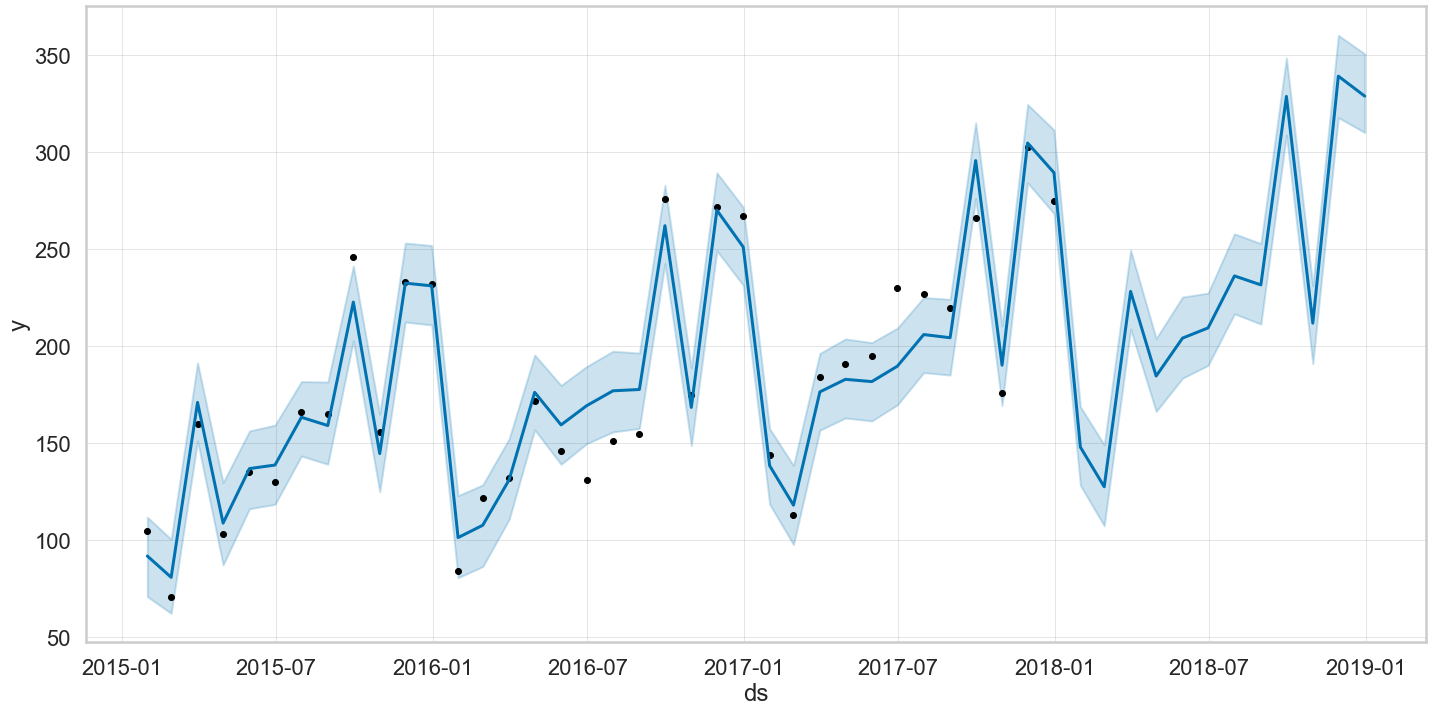

In [21]:
#Plot the Forecast
fig1 = model.plot(forecast, figsize=(20,10))

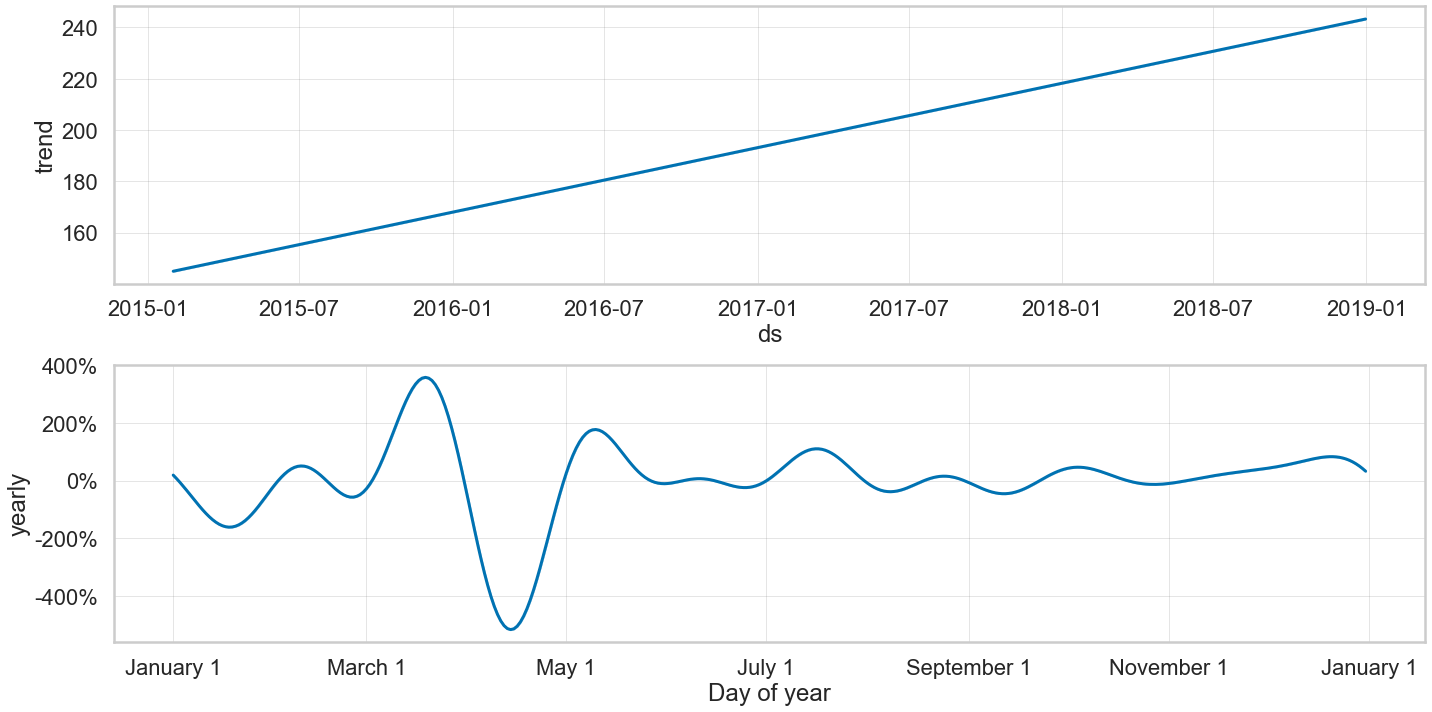

In [22]:
#Plot the Components
fig2 = model.plot_components(forecast, figsize=(20,10))

In [23]:
#Join with actual results to get the metrics 
results_df = pd.merge(forecast, monthly, left_on='ds', right_index=True)
results_df = results_df[['ds','Completed_requests','yhat']]
results_df.head()

,ds,Completed_requests,yhat
0,2015-01-31,105,91.917973
1,2015-02-28,71,80.911195
2,2015-03-31,160,171.098331
3,2015-04-30,103,108.859349
4,2015-05-31,135,136.959287


In [24]:
train_results = results_df[(results_df.ds.dt.year < 2018)]
test_results = results_df[(results_df.ds.dt.year == 2018)]

In [25]:
#Train Metrics
forecast_metrics(train_results.Completed_requests,train_results.yhat)

MAE: 12.41
MSE: 250.95
RMSE: 15.84
MAPE: 7.59


In [26]:
forecast_metrics(test_results.Completed_requests,test_results.yhat)

MAE: 43.02
MSE: 2236.06
RMSE: 47.29
MAPE: 16.54


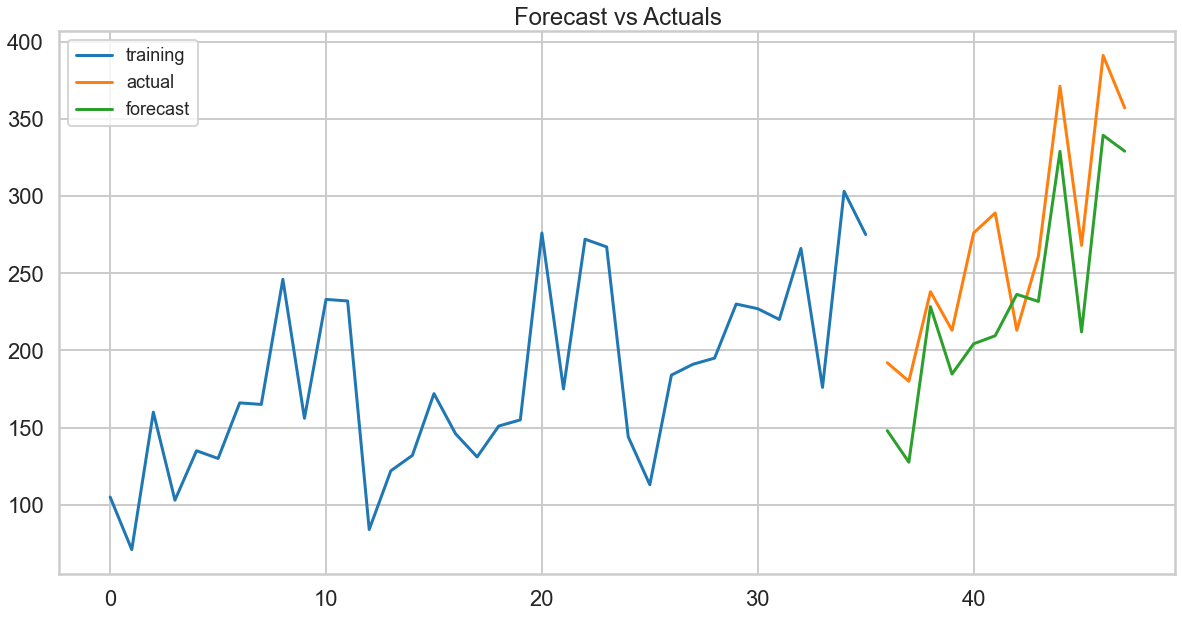

In [27]:
# Plot
plt.figure(figsize=(20,10))
plt.plot(train_results.Completed_requests, label='training')
plt.plot(test_results.Completed_requests, label='actual')
plt.plot(test_results.yhat, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=18)
plt.show()